In [1]:
setwd("T:/PIgroup Nael NadifKasri/Sofia/2025/MEA_seq_patient/Analysis/Developmental")

In [2]:
library(RColorBrewer)
library(tidyverse)
library(reshape2)
library(dplyr)
library(emmeans)
library(car)
library(pheatmap)
library(mgcv)

Warning message:
"package 'tidyverse' was built under R version 4.2.3"
Warning message:
"package 'tibble' was built under R version 4.2.3"
Warning message:
"package 'tidyr' was built under R version 4.2.3"
Warning message:
"package 'readr' was built under R version 4.2.3"
Warning message:
"package 'purrr' was built under R version 4.2.3"
Warning message:
"package 'dplyr' was built under R version 4.2.3"
Warning message:
"package 'stringr' was built under R version 4.2.3"
Warning message:
"package 'forcats' was built under R version 4.2.3"
Warning message:
"package 'lubridate' was built under R version 4.2.3"
── Attaching core tidyverse packages ──────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.2     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ───────────────────────────────────────────────────────────────────

In [3]:
n_colors <- c("cluster_1"="#CDCD00","cluster_2"="#00CDCD","cluster_3"="#FF1493","cluster_4"="#999999","cluster_5"="#009933","cluster_6"="#3399FF")


In [4]:
# Set contrasts for Type III ANOVA
options(contrasts = c("contr.sum", "contr.poly"))

In [5]:
cell_lines<-read.csv("T:/PIgroup Nael NadifKasri/Sofia/2025/MEA_seq_patient/Code/0.Data/cell_lines/cell_lines.csv")


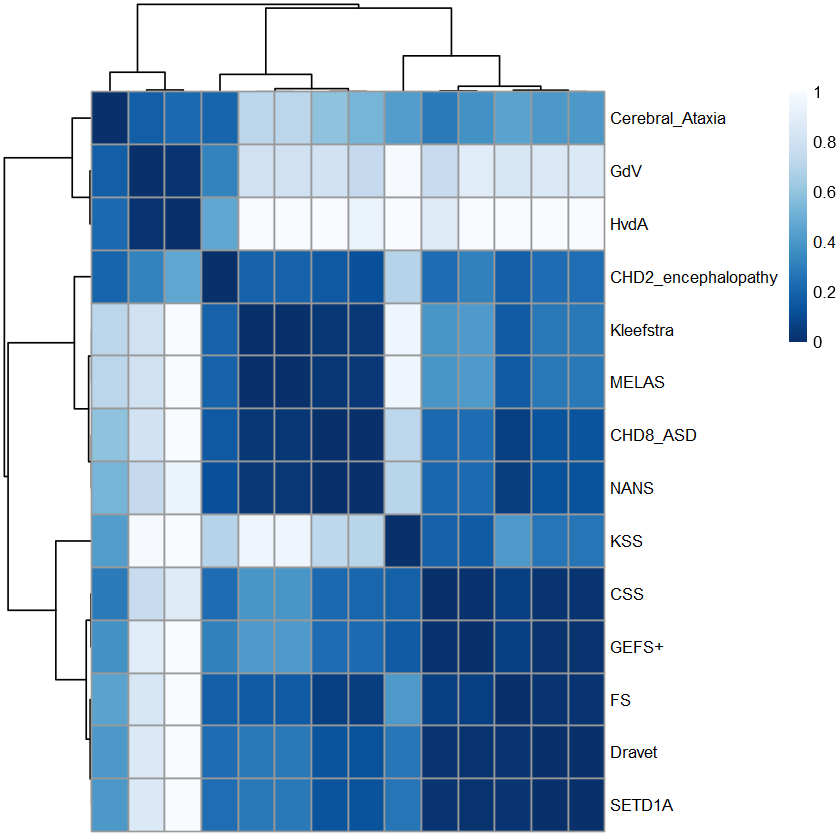

In [12]:
files <- list.files(pattern = "^MEA_features_dev.*\\.csv$")

for (file in files) {
  dir_name <- tools::file_path_sans_ext(file)
  if (!dir.exists(dir_name)) dir.create(dir_name)
  
  data <- read.csv(file, stringsAsFactors = FALSE)
  data <- data[-1]
  data$cell_line<-cell_lines$cell_line_v2[match(data$Phenotype,cell_lines$Phenotype)]
  rownames(data) <- data$Row.names
  data$Row.names <- NULL
  
  numeric_variables <- names(data)[sapply(data, is.numeric) & !(names(data) %in% c("DIV_int"))]
  
  # Store results for interaction, DIV main effect, cluster main effect
  lm_results <- data.frame(
    Variable = character(),
    p_DIV = numeric(),
    p_cluster = numeric(),
    p_interaction = numeric(),
    F_interaction=numeric(),
    stringsAsFactors = FALSE
  )
  
  all_comparisons <- list()
  all_coefs <- list()   # <--- define here
  for (var in numeric_variables) {
    new <- data[, c(var, "DIV_int", "dev_cluster")]
    new$DIV_int <- factor(new$DIV_int)
    new$dev_cluster <- factor(new$dev_cluster)
    
    # Set sum contrasts for type III ANOVA correctness
    contrasts(new$DIV_int) <- contr.sum(length(levels(new$DIV_int)))
    contrasts(new$dev_cluster) <- contr.sum(length(levels(new$dev_cluster)))
    
    model <- lm(as.formula(paste(var, "~ DIV_int * dev_cluster")), data = new)
    anova_res <- car::Anova(model, type = "III")
    # Extract coefficients and store
    coefs <- summary(model)$coefficients
    coefs_df <- as.data.frame(coefs)
    coefs_df$Variable <- var
    coefs_df$Term <- rownames(coefs)
    all_coefs[[var]] <- coefs_df   # <--- store coefficients
    
    # Extract p-values safely
    p_DIV <- tryCatch(anova_res["DIV_int", "Pr(>F)"], error = function(e) NA)
    p_cluster <- tryCatch(anova_res["dev_cluster", "Pr(>F)"], error = function(e) NA)
    p_interaction <- tryCatch(anova_res["DIV_int:dev_cluster", "Pr(>F)"], error = function(e) NA)
     F_interaction <-  tryCatch(anova_res["DIV_int:dev_cluster", "F value"], error = function(e) NA)
    lm_results <- rbind(lm_results, data.frame(
      Variable = var,
      p_DIV = p_DIV,
      p_cluster = p_cluster,
      p_interaction = p_interaction,
        F_interaction = F_interaction,
      stringsAsFactors = FALSE
    ))
    
    pairwise_comparisons <- tryCatch({
      emm <- emmeans(model, ~ dev_cluster | DIV_int)
      pairs_df <- as.data.frame(pairs(emm))
      pairs_df$Variable <- var
      pairs_df
    }, error = function(e) NULL)
    
    if (!is.null(pairwise_comparisons)) {
      all_comparisons[[var]] <- pairwise_comparisons
    }
    
    summary_stats <- new %>%
      group_by(DIV_int, dev_cluster) %>%
      summarise(
        mean = mean(.data[[var]], na.rm = TRUE),
        sd = sd(.data[[var]], na.rm = TRUE),
        .groups = "drop"
      )
    
    p <- ggplot(summary_stats, aes(x = DIV_int, y = mean, group = dev_cluster, color = dev_cluster)) +
      geom_line(size = 2) +
      scale_color_manual(values = n_colors) +
      geom_ribbon(aes(ymin = mean - sd, ymax = mean + sd, fill = dev_cluster), alpha = 0.3) +
      scale_fill_manual(values = n_colors) +
      theme_minimal() +
      labs(x = "DIV (categorical)", y = paste("Mean", var))
    
    ggsave(file.path(dir_name, paste0(var, ".pdf")), plot = p, width = 6, height = 3, bg = "transparent")
  }
  
  # Adjust interaction p-values across variables for multiple testing
  # Adjust p-values for multiple testing (FDR correction) across variables
 # lm_results$p_DIV_adj <- p.adjust(lm_results$p_DIV, method = "fdr")
  #lm_results$p_cluster_adj <- p.adjust(lm_results$p_cluster, method = "fdr")
  #lm_results$p_interaction_adj <- p.adjust(lm_results$p_interaction, method = "fdr")
  #adjust globally 
    # Combine all p-values from DIV, cluster, and interaction into a single vector
  all_pvals <- c(lm_results$p_DIV, lm_results$p_cluster, lm_results$p_interaction)

  # Apply global FDR correction across all p-values
  all_pvals_adj <- p.adjust(all_pvals, method = "fdr")

  # Split the adjusted p-values back to their respective terms
  n <- nrow(lm_results)
  lm_results$p_DIV_adj <- all_pvals_adj[1:n]
  lm_results$p_cluster_adj <- all_pvals_adj[(n + 1):(2 * n)]
  lm_results$p_interaction_adj <- all_pvals_adj[(2 * n + 1):(3 * n)]
              
   # Optional: reorder columns for clarity
  lm_results <- lm_results %>%
    dplyr::select(
      Variable,
      p_DIV, p_DIV_adj,
      p_cluster, p_cluster_adj,
      p_interaction, p_interaction_adj,
      F_interaction
    )
  # Save results with adjusted p-values
  write.csv(lm_results, file = file.path(dir_name, "lm_interaction_results.csv"), row.names = FALSE)
  #rank and plot
  lm_results <- lm_results %>%
      arrange(desc(F_interaction), p_interaction_adj)
  ranked_vars <- lm_results$Variable  # ranked list of variables
  
  # Gather all summary data again for ranked plotting
  summary_long <- data.frame()
  
  for (var in ranked_vars) {
    tmp <- data %>%
      group_by(DIV_int, dev_cluster) %>%
      summarise(
        mean = mean(.data[[var]], na.rm = TRUE),
        sd   = sd(.data[[var]], na.rm = TRUE),
        .groups = "drop"
      )
    tmp$Variable <- var
    summary_long <- rbind(summary_long, tmp)
  }
  
  summary_long$Variable <- factor(summary_long$Variable, levels = ranked_vars)
   # Convert DIV_int into categorical labels: DIV28–DIV49
  summary_long$DIV_int <- factor(
    summary_long$DIV_int,
    levels = c(28, 35, 42, 49),
    labels = c("DIV28", "DIV35", "DIV42", "DIV49")
  )
  
  ranked_plot <- ggplot(summary_long, aes(x = DIV_int, y = mean, group = dev_cluster, color = dev_cluster, fill = dev_cluster)) +
    geom_line(size = 2) +
    geom_ribbon(aes(ymin = mean - sd, ymax = mean + sd), alpha = 0.3, color = NA) +
    scale_color_manual(values = n_colors) +
    scale_fill_manual(values = n_colors) +
    facet_wrap(~Variable, scales = "fixed", ncol = 4) +
    theme_minimal() +
    theme(  text = element_text(color = "black"),
      axis.text.x = element_text(angle = 45, hjust = 1),
     # axis.text.y = element_text(size = 6),
      #strip.text = element_text(size = 6),
      panel.background = element_rect(fill = NA, colour = NA),
      plot.background = element_rect(fill = NA, colour = NA),
      legend.position = "bottom",
      legend.text = element_text(size = 6)
    ) +
    labs(
      x = "DIV",
      y = "scaled change",
      title = "Variables ranked by development × cluster interaction"
    )
  
  ggsave(
    file.path(dir_name, "ranked_variables_lineplots.pdf"),
    plot = ranked_plot,
    width = 8.27, height = 11.69,#A4
    bg = "transparent"
  )
                                     

  # Compute cluster proportions per cell line within syndrome
    cellline_props <- data %>%
      group_by(Syndrome, cell_line, dev_cluster) %>%
      summarise(count = n(), .groups = "drop") %>%
      group_by(Syndrome, cell_line) %>%
      mutate(prop = count / sum(count)) %>%
      ungroup()
    
    # Average proportions across cell lines for each syndrome
    syndrome_props_avg <- cellline_props %>%
      group_by(Syndrome, dev_cluster) %>%
      summarise(mean_prop = mean(prop), .groups = "drop") %>%
      tidyr::pivot_wider(names_from = dev_cluster, values_from = mean_prop, values_fill = 0)
    
    # Compute distance matrix based on averaged proportions
    syndrome_matrix <- as.matrix(syndrome_props_avg[, -1])  # remove Syndrome column
    rownames(syndrome_matrix) <- syndrome_props_avg$Syndrome
    sampleDists <- proxy::dist(syndrome_matrix, method = "cosine")
    sampleDistMatrix <- as.matrix(sampleDists)
    colors <- colorRampPalette(rev(brewer.pal(9, "Blues")))(255)
    
    # Hierarchical clustering heatmap
    p <- pheatmap(sampleDistMatrix,
                  clustering_distance_rows = sampleDists,
                  clustering_distance_cols = sampleDists,
                   show_colnames = FALSE,  # hide column names
                  col = colors)
    ggsave(file.path(dir_name, "hierarchical_clustering_development.pdf"), plot = p, bg = "transparent", width = 5, height = 3)

# Extract syndrome order from dendrogram

  syndrome_order <- p[[4]][[1]][[3]][[4]][[1]][[9]][[1]]
  syndrome_order <- rownames(syndrome_order)
  # Make dataframe for plotting
  
#  dg <- as.data.frame(syndrome_counts)
#  colnames(dg) <- c("Syndrome", "cluster", "count")
#  dg$percentage <- dg$count / tapply(dg$count, dg$Syndrome, sum)[dg$Syndrome] * 100
  # Prepare a data frame for syndrome-cluster proportions
  dg <- data  %>%
    group_by(Syndrome, dev_cluster) %>%
    summarise(count = n(), .groups = "drop") %>%
    group_by(Syndrome) %>%
    mutate(percentage = count / sum(count) * 100) %>%
    ungroup()

# Rename for clarity
  colnames(dg)[colnames(dg) == "dev_cluster"] <- "cluster"

  # Apply the clustered order
  dg$Syndrome <- factor(dg$Syndrome, levels = syndrome_order)
  dg$cluster <- factor(dg$cluster, levels = unique(dg$cluster))
  
  # Barplot
  p_syndrome <- ggplot(dg, aes(x = Syndrome, y = percentage, fill = cluster)) +
    geom_bar(stat = "identity") +
    scale_fill_manual(values = n_colors) +
    theme_minimal() +
    theme(axis.text.x = element_text(size = 10, angle = 45, vjust = 1, hjust = 1)) +
    labs(y = "Percentage")
  
  # Save plots
  ggsave(file.path(dir_name, "Syndrome_by_cluster_cell_line_Average.pdf"), plot = p_syndrome, bg = "transparent", width = 7, height = 5)
}